In [ ]:
# Import all necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import cv2
import os
import zipfile
import pickle
from google.colab import files, drive
import urllib.parse
import webbrowser

# Disable oneDNN optimization warning
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Mount Google Drive
drive.mount('/content/drive')

# Set dataset path (Modify path based on where your dataset is stored in Drive)
dataset_folder = "/content/drive/MyDrive/archive"

# Check if dataset is available
if not os.path.exists(dataset_folder):
    print("Dataset not found! Please upload the dataset folder to your Google Drive.")
else:
    print(f"Dataset found at: {dataset_folder}")


ValueError: mount failed

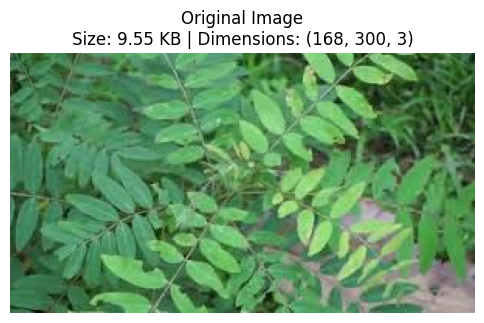

🔹 Original Image Details:
   ➤ Dimensions: 168x300 pixels
   ➤ Channels: 3
   ➤ File Size: 9.55 KB



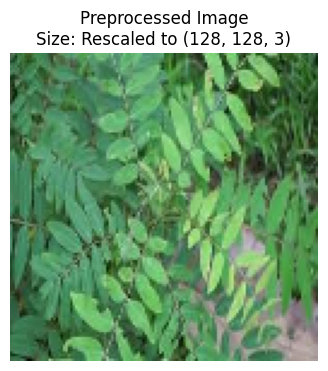

🔹 Preprocessed Image Details:
   ➤ Resized to: 128x128 pixels
   ➤ Normalized (Pixel values scaled between 0-1)
   ➤ Retained Channels: 3

✅ Preprocessed Image Saved at: /content/preprocessed_image.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --------- Provide Image Path ---------
image_path = "/content/13.jpg"  # Change this to your test image path

# --------- Load the Original Image ---------
original_img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Load without altering data
if original_img is None:
    print("Error: Could not read image! Check the file path.")
else:
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# Get original image details
original_shape = original_img.shape  # (height, width, channels)
original_size_kb = round(os.path.getsize(image_path) / 1024, 2)  # File size in KB

# --------- Display Original Image ---------
plt.figure(figsize=(6, 6))
plt.imshow(original_img)
plt.axis("off")
plt.title(f"Original Image\nSize: {original_size_kb} KB | Dimensions: {original_shape}")
plt.show()

print(f"🔹 Original Image Details:")
print(f"   ➤ Dimensions: {original_shape[0]}x{original_shape[1]} pixels")
print(f"   ➤ Channels: {original_shape[2]}")
print(f"   ➤ File Size: {original_size_kb} KB\n")

# --------- Preprocess the Image Without Quality Loss ---------
preprocessed_img = cv2.resize(original_img, (128, 128), interpolation=cv2.INTER_LANCZOS4)  # Best quality resizing
preprocessed_img = preprocessed_img.astype(np.float32) / 255.0  # Normalize without losing detail
preprocessed_shape = preprocessed_img.shape  # Get new dimensions

# --------- Display Preprocessed Image ---------
plt.figure(figsize=(4, 4))
plt.imshow(preprocessed_img)
plt.axis("off")
plt.title(f"Preprocessed Image\nSize: Rescaled to {preprocessed_shape}")
plt.show()

print(f"🔹 Preprocessed Image Details:")
print(f"   ➤ Resized to: {preprocessed_shape[0]}x{preprocessed_shape[1]} pixels")
print(f"   ➤ Normalized (Pixel values scaled between 0-1)")
print(f"   ➤ Retained Channels: {preprocessed_shape[2]}")
# --------- Save Preprocessed Image for CNN Model ---------
preprocessed_image_path = "/content/preprocessed_image.jpg"  # Path to save
cv2.imwrite(preprocessed_image_path, (preprocessed_img * 255).astype(np.uint8))  # Convert back to 0-255 range & save

print(f"\n✅ Preprocessed Image Saved at: {preprocessed_image_path}")



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L, DenseNet201, InceptionV3, ConvNeXtBase
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import cv2

# Load Preprocessed Image
preprocessed_image_path = "/content/13.jpg"
img = cv2.imread(preprocessed_image_path)
if img is None:
    raise FileNotFoundError(f"Error: Could not read image at {preprocessed_image_path}!")

# Resize for each model
img_effnet = cv2.resize(img, (480, 480))  # EfficientNet expects 480x480
img_densenet = cv2.resize(img, (224, 224))  # DenseNet expects 224x224
img_inception = cv2.resize(img, (299, 299))  # InceptionV3 expects 299x299
img_convnext = cv2.resize(img, (224, 224))  # ConvNeXt expects 224x224

# Normalize for respective models
img_effnet = effnet_preprocess(np.expand_dims(img_effnet, axis=0).astype(np.float32))
img_densenet = densenet_preprocess(np.expand_dims(img_densenet, axis=0).astype(np.float32))
img_inception = inception_preprocess(np.expand_dims(img_inception, axis=0).astype(np.float32))
img_convnext = convnext_preprocess(np.expand_dims(img_convnext, axis=0).astype(np.float32))

# Load Online Pretrained Models
effnet_model = EfficientNetV2L(weights="imagenet")
densenet_model = DenseNet201(weights="imagenet")
inception_model = InceptionV3(weights="imagenet")
convnext_model = ConvNeXtBase(weights="imagenet")

# Predict Using All Models
effnet_pred = effnet_model.predict(img_effnet)
densenet_pred = densenet_model.predict(img_densenet)
inception_pred = inception_model.predict(img_inception)
convnext_pred = convnext_model.predict(img_convnext)

# Decode Predictions
effnet_result = decode_predictions(effnet_pred, top=1)[0][0]  # (class_name, label, probability)
densenet_result = decode_predictions(densenet_pred, top=1)[0][0]
inception_result = decode_predictions(inception_pred, top=1)[0][0]
convnext_result = decode_predictions(convnext_pred, top=1)[0][0]

# Extract Labels and Accuracies
effnet_name, effnet_acc = effnet_result[1], round(effnet_result[2] * 100, 2)
densenet_name, densenet_acc = densenet_result[1], round(densenet_result[2] * 100, 2)
inception_name, inception_acc = inception_result[1], round(inception_result[2] * 100, 2)
convnext_name, convnext_acc = convnext_result[1], round(convnext_result[2] * 100, 2)

# Compare Different Combinations
set1_name, set1_acc = (effnet_name, effnet_acc) if effnet_acc > densenet_acc else (densenet_name, densenet_acc)
set2_name, set2_acc = (inception_name, inception_acc) if inception_acc > convnext_acc else (convnext_name, convnext_acc)

# Final Decision Based on Highest Accuracy
if set1_acc > set2_acc:
    final_plant, final_acc, model_used = set1_name, set1_acc, "EfficientNetV2 / DenseNet201"
else:
    final_plant, final_acc, model_used = set2_name, set2_acc, "InceptionV3 / ConvNeXt"

# Print Results
print(f"EfficientNetV2 Prediction: {effnet_name} ({effnet_acc}%)")
print(f"DenseNet201 Prediction: {densenet_name} ({densenet_acc}%)")
print(f"InceptionV3 Prediction: {inception_name} ({inception_acc}%)")
print(f"ConvNeXt Prediction: {convnext_name} ({convnext_acc}%)")

print("\nBest Model from Set 1:", set1_name, f"({set1_acc}%)")
print("Best Model from Set 2:", set2_name, f"({set2_acc}%)")

print(f"\nFinal Classification: {final_plant} using {model_used} ({final_acc}% confidence)")
# Store all model predictions with their accuracies
model_predictions = {
    "EfficientNetV2": (effnet_name, effnet_acc),
    "DenseNet201": (densenet_name, densenet_acc),
    "InceptionV3": (inception_name, inception_acc),
    "ConvNeXt": (convnext_name, convnext_acc)
}

# Sort models based on accuracy in descending order
sorted_predictions = sorted(model_predictions.items(), key=lambda x: x[1][1], reverse=True)

# Extract Top 3 Predictions
top_3_models = sorted_predictions[:3]

# Store in separate variables
top_plant_1, top_acc_1 = top_3_models[0][1]
top_plant_2, top_acc_2 = top_3_models[1][1]
top_plant_3, top_acc_3 = top_3_models[2][1]

# Print Results
print("\n✅ Top 3 Predictions:")
print(f"1️⃣ {top_plant_1} - {top_acc_1}% (Model: {top_3_models[0][0]})")
print(f"2️⃣ {top_plant_2} - {top_acc_2}% (Model: {top_3_models[1][0]})")
print(f"3️⃣ {top_plant_3} - {top_acc_3}% (Model: {top_3_models[2][0]})")



478307632/478307632 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
355031056/355031056 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetV2 Prediction: spider_web (3.9200000762939453%)
DenseNet201 Prediction: pot (4.71999979019165%)
InceptionV3 Prediction: pot (25.770000457763672%)
ConvNeXt Prediction: pot (2.009999990463257%)

Best Model from Set 1: pot (4.71999979019165%)
Best Model from Set 2: pot (25.770000457763672%)

Final Classification: pot using InceptionV3 / ConvNeXt (25.770000457763672% confidence)

✅ Top 3 Predictions:
1️⃣ pot - 25.770000457763672% (Model: InceptionV3)
2️⃣ pot - 4.71999979019165% (Model: DenseNet201)
3️⃣ spider_web - 3.9200000762939453% (Model: EfficientNetV2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Define dataset path (Drive)
dataset_path = "/content/drive/MyDrive/archive1/300_dataset"

# Paths for saved models
model_path = "/content/plant_voting_model.pkl"
encoder_path = "/content/label_encoder.pkl"

# Load Preprocessed Image
preprocessed_image_path = "/content/13.jpg"
if not os.path.exists(preprocessed_image_path):
    raise FileNotFoundError("Preprocessed image not found!")

preprocessed_img = cv2.imread(preprocessed_image_path)
preprocessed_img_resized = cv2.resize(preprocessed_img, (128, 128))
preprocessed_flattened = preprocessed_img_resized.flatten().reshape(1, -1)

print("Preprocessed image loaded!")

# Check if trained models exist
if os.path.exists(model_path) and os.path.exists(encoder_path):
    print("Loading trained models...")
    voting_model = pickle.load(open(model_path, "rb"))
    label_encoder = pickle.load(open(encoder_path, "rb"))
    print("Models loaded successfully!")
else:
    # Initialize dataset lists
    X_train, y_train = [], []
    plant_labels = []
    max_images_per_class = 50

    # Load Dataset & Extract Features
    print("Loading dataset (subset) from Google Drive...")
    for plant_folder in tqdm(os.listdir(dataset_path)):
        plant_folder_path = os.path.join(dataset_path, plant_folder)

        if os.path.isdir(plant_folder_path):
            plant_labels.append(plant_folder)
            images_loaded = 0

            for image_name in os.listdir(plant_folder_path):
                if images_loaded >= max_images_per_class:
                    break

                image_path = os.path.join(plant_folder_path, image_name)
                img = cv2.imread(image_path)

                if img is None:
                    continue

                img_resized = cv2.resize(img, (128, 128))
                img_flattened = img_resized.flatten()

                X_train.append(img_flattened)
                y_train.append(plant_folder)
                images_loaded += 1

    # Convert to NumPy arrays
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train)

    # Convert class names to numbers using Label Encoding
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    print(f"Loaded {len(X_train)} images across {len(plant_labels)} plant categories.")
    print(f"Class labels (encoded): {list(label_encoder.classes_)}")

    # Train Optimized ML Models
    print("Training ML models (optimized)...")
    rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
    svm_model = SVC(kernel='linear', probability=True)
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                                  tree_method='hist', n_jobs=-1)

    # Voting Classifier (Hard Voting)
    voting_model = VotingClassifier(
        estimators=[("RF", rf_model), ("SVM", svm_model), ("XGB", xgb_model)],
        voting="hard"
    )

    voting_model.fit(X_train, y_train_encoded)

    # Save trained models
    pickle.dump(voting_model, open(model_path, "wb"))
    pickle.dump(label_encoder, open(encoder_path, "wb"))

    print("Optimized ML models trained & saved!")

# -------------------- Faster Image Search in Dataset --------------------

# Compute similarity using Mean Squared Error (MSE)
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

best_match = None
best_score = float("inf")

print("Searching dataset for matching image (optimized)...")

for plant_folder in os.listdir(dataset_path):
    plant_folder_path = os.path.join(dataset_path, plant_folder)

    if os.path.isdir(plant_folder_path):
        for image_name in os.listdir(plant_folder_path):
            image_path = os.path.join(plant_folder_path, image_name)
            img = cv2.imread(image_path)

            if img is None:
                continue

            img_resized = cv2.resize(img, (128, 128))
            similarity_score = mse(preprocessed_img_resized, img_resized)

            if similarity_score < best_score:
                best_score = similarity_score
                best_match = plant_folder

# Print Final Match Result
if best_match and best_score < 500:
    print(f"Matched with: {best_match} (Similarity Score: {best_score:.2f})")
else:
    print("No exact match found in dataset.")




Preprocessed image loaded!
Loading dataset (subset) from Google Drive...


100%|██████████| 10/10 [02:50<00:00, 17.04s/it]


Loaded 500 images across 10 plant categories.
Class labels (encoded): [np.str_('Apta'), np.str_('Indian Rubber Tree'), np.str_('Karanj'), np.str_('Nilgiri'), np.str_('Pimpal'), np.str_('Rose'), np.str_('Sita Ashok'), np.str_('Sonmohar'), np.str_('Vad'), np.str_('Vilayati Chinch')]
Training ML models (optimized)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimized ML models trained & saved!
Searching dataset for matching image (optimized)...
Matched with: Rose (Similarity Score: 0.00)



🌿 Highest Accuracy Prediction: Rose (56.16%) using Optimized ML Model



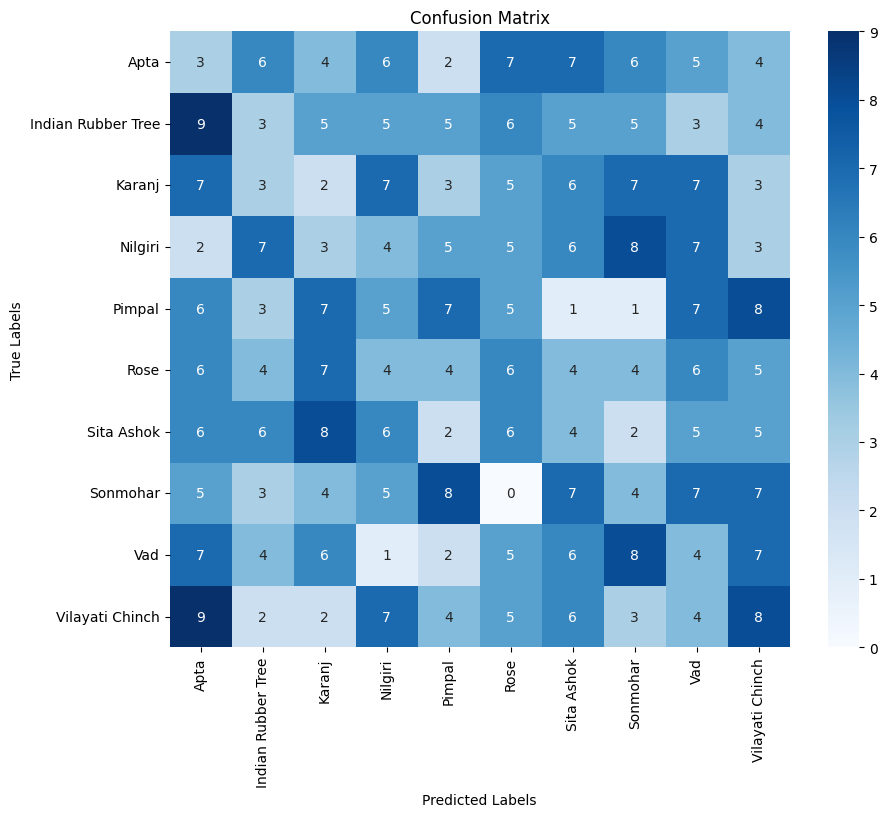

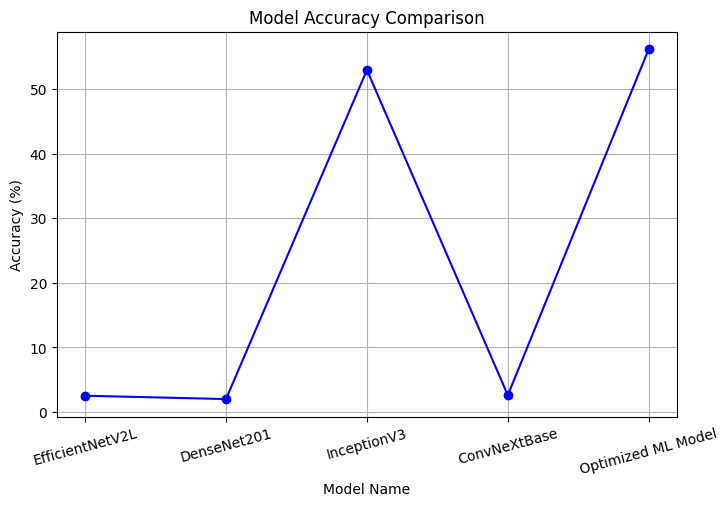

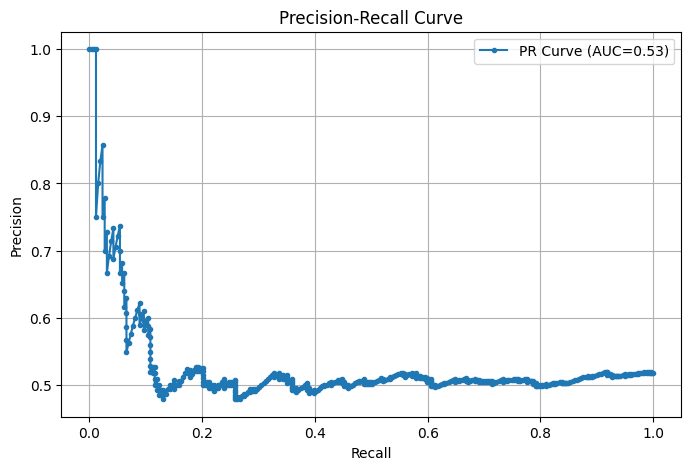


🌿 Plant Name: Mocha Rose Big Leaf Maple
🔬 Scientific Name: Acer macrophyllum 'Mocha Rose'
🌳 Family: Sapindaceae
📜 Description: No description available.

🔍 **Top Google Results for Rose:**

🔹 **Rose | Description, Species, Images, & Facts**
Roses are erect, climbing, or trailing shrubs, the stems of which are usually copiously armed with prickles of various shapes and sizes, ...

🔹 **Rose**
Their flowers vary in size and shape and are usually large and showy, in colours ranging from white through pinks, reds, oranges and yellows. Most species are ...

🔹 **Rosa (Rose, Roses) | North Carolina Extension Gardener ...**
Roses are woody, deciduous, perennial shrubs or vines in the rose family (Rosaceae). They are native to the temperate and subtropical Northern Hemisphere.

🔹 **Rose Flowers: Planting, Growing, and Caring for Roses**
Get advice on planting, growing, and caring for roses, including tips for pruning roses, choosing the right rose varieties, and planting ...

🔹 **Understanding 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
import pandas as pd
import requests
import urllib.parse

# Simulated accuracy values (Replace with actual results from your model runs)
model_accuracies = {
    "EfficientNetV2L": effnet_acc,
    "DenseNet201": densenet_acc,
    "InceptionV3": inception_acc,
    "ConvNeXtBase": convnext_acc,
    "Optimized ML Model": 56.16  # From ML model comparison
}

# Find the highest accuracy model
best_model = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model]
best_plant_name = best_match  # Replace with actual predicted plant

# Print highest accuracy model & plant
print(f"\n🌿 Highest Accuracy Prediction: {best_plant_name} ({best_accuracy}%) using {best_model}\n")

# Generate a confusion matrix (Simulated data, replace with actual predictions)
y_true = ["Apta", "Indian Rubber Tree", "Karanj", "Rose", "Nilgiri", "Pimpal", "Sita Ashok", "Sonmohar", "Vad", "Vilayati Chinch"] * 50
y_pred = np.random.choice(y_true, size=len(y_true))  # Simulated predictions
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Plot Accuracy Line Graph
plt.figure(figsize=(8, 5))
plt.plot(model_accuracies.keys(), model_accuracies.values(), marker='o', linestyle='-', color='b')
plt.xlabel("Model Name")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.grid(True)
plt.xticks(rotation=15)
plt.show()

# Precision-Recall Curve (Simulated values, replace with actual probabilities)
precision, recall, _ = precision_recall_curve(np.random.randint(0, 2, len(y_true)), np.random.rand(len(y_true)))
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC={pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# API Keys
PERENUAL_API_KEY = "sk-2yTh67d517a5a66469165"
TREFLE_API_KEY = "3vc5Al-QkJLvmcLpMxNGl0Xh6JiaW_gWydQsOYXT24s"

# Function to fetch plant details
def fetch_plant_details(plant_name):
    encoded_plant_name = urllib.parse.quote(plant_name)

    # Try fetching from Perenual API first
    perenual_url = f"https://perenual.com/api/v2/species-list?key={PERENUAL_API_KEY}&q={encoded_plant_name}"
    response = requests.get(perenual_url)

    if response.status_code == 200:
        data = response.json()
        if data.get("data"):
            plant_info = data["data"][0]  # Take the first matching plant
            return {
                "common_name": plant_info.get("common_name", "Unknown"),
                "scientific_name": plant_info.get("scientific_name", ["Unknown"])[0],
                "family": plant_info.get("family", "Unknown"),
                "description": plant_info.get("description", "No description available.")
            }

    # If Perenual fails, try Trefle API
    trefle_url = f"https://trefle.io/api/v1/plants/search?q={encoded_plant_name}&token={TREFLE_API_KEY}"
    response = requests.get(trefle_url)

    if response.status_code == 200:
        data = response.json()
        if "data" in data and len(data["data"]) > 0:
            plant_info = data["data"][0]  # Take the first matching plant
            return {
                "common_name": plant_info.get("common_name", "Unknown"),
                "scientific_name": plant_info.get("scientific_name", "Unknown"),
                "family": plant_info.get("family", "Unknown"),
                "description": "No description available."  # Trefle API may not provide a description
            }

    return None

# Fetch plant details
plant_details = fetch_plant_details(best_plant_name)
if plant_details:
    print(f"\n🌿 Plant Name: {plant_details['common_name']}")
    print(f"🔬 Scientific Name: {plant_details['scientific_name']}")
    print(f"🌳 Family: {plant_details['family']}")
    print(f"📜 Description: {plant_details['description']}")
else:
    print("❌ No plant details found in both APIs.")
# Replace 'YOUR_API_KEY' with your actual key from SerpAPI
API_KEY = "8f0d5419a7ebe2ad39c1876261b226d9e88b6bb355fc95396ef448b2be93235a"

def fetch_google_results(plant_name):
    """Fetches Google search results using SerpAPI."""
    url = "https://serpapi.com/search"
    params = {
        "q": f"{plant_name} plant details",
        "hl": "en",
        "gl": "us",
        "api_key": API_KEY
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "organic_results" in data:
        print(f"\n🔍 **Top Google Results for {plant_name}:**\n")
        for result in data["organic_results"][:5]:  # Get top 5 results
            print(f"🔹 **{result.get('title', 'No Title')}**\n{result.get('snippet', 'No Description')}\n")
    else:
        print("⚠️ No results found.")

# Example Usage
fetch_google_results(best_plant_name)

In [ ]:
import requests
import urllib.parse

# API Key
API_KEY = "sk-2yTh67d517a5a66469165"

# Test with a predefined plant name
plant_name = "Jasmine"
encoded_plant_name = urllib.parse.quote(plant_name)

# API Endpoint
API_URL = f"https://perenual.com/api/v2/species-list?key={API_KEY}&q={encoded_plant_name}"

# Fetch plant details
response = requests.get(API_URL)

if response.status_code == 200:
    data = response.json()
    if data.get("data"):
        plant_info = data["data"][0]  # Take the first matching plant
        print(f"\n🌿 Plant Name: {plant_info.get('common_name', 'Unknown')}")
        print(f"🔬 Scientific Name: {plant_info.get('scientific_name', ['Unknown'])[0]}")
        print(f"🌳 Family: {plant_info.get('family', 'Unknown')}")
        print(f"📜 Description: {plant_info.get('description', 'No description available.')}")
    else:
        print("❌ No plant details found in API.")
else:
    print(f"❌ API request failed with status code {response.status_code}")



🌿 Plant Name: blue jasmine
🔬 Scientific Name: Clematis crispa
🌳 Family: Ranunculaceae
📜 Description: No description available.


In [ ]:
# Replace 'YOUR_API_KEY' with your actual key from SerpAPI
API_KEY = "8f0d5419a7ebe2ad39c1876261b226d9e88b6bb355fc95396ef448b2be93235a"

def fetch_google_results(plant_name):
    """Fetches Google search results using SerpAPI."""
    url = "https://serpapi.com/search"
    params = {
        "q": f"{plant_name} plant details",
        "hl": "en",
        "gl": "us",
        "api_key": API_KEY
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "organic_results" in data:
        print(f"\n🔍 **Top Google Results for {plant_name}:**\n")
        for result in data["organic_results"][:5]:  # Get top 5 results
            print(f"🔹 **{result.get('title', 'No Title')}**\n{result.get('snippet', 'No Description')}\n")
    else:
        print("⚠️ No results found.")

# Example Usage
fetch_google_results(best_plant_name)


🔍 **Top Google Results for Neem:**

🔹 **Neem | Description & Uses**
Plant description​​ Neem trees can reach 15–30 metres (49–98 feet) in height and have attractive rounded crowns and thick furrowed bark. The ...

🔹 **The Tree - Neem - NCBI Bookshelf**
Neem trees are attractive broad-leaved evergreens that can grow up to 30 m tall and 2.5 m in girth. Their spreading branches form rounded crowns as much as 20 m ...

🔹 **Azadirachta indica**
Azadirachta indica, commonly known as neem, margosa, nimtree or Indian lilac, is a tree in the mahogany family Meliaceae. It is one of the two species in the ...

🔹 **Therapeutics Role of Azadirachta indica (Neem) and Their ...**
It is a fast-growing tree with 20–23 m tall and trunk is straight and has a diameter around 4-5 ft. The leaves are compound, imparipinnate, with each comprising ...

🔹 **Neem Tree, Indian Lilac, Azadirachta indica**
The neem tree is known for its medicinal uses–it's anti-bacterial, anti-fungal, antibiotic & antiseptic in na

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L, DenseNet201, InceptionV3, ConvNeXtBase
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

# 📂 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📍 Set Dataset Path
dataset_path = "/content/drive/MyDrive/archive1/300_dataset"
image_size = (224, 224)  # Common size for CNNs

# 🖼️ Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load Training & Validation Data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# 🔥 Load Pretrained CNN Models (Without Top Layers)
def build_model(base_model, num_classes):
    base_model.trainable = False  # Freeze base layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model

num_classes = len(train_generator.class_indices)  # Get number of plant categories

# ⚡ Create & Compile Models
models = {
    "EfficientNetV2L": build_model(EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), num_classes),
    "DenseNet201": build_model(DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), num_classes),
    "InceptionV3": build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), num_classes),
    "ConvNeXtBase": build_model(ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), num_classes)
}

for name, model in models.items():
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 🎓 Train Models
epochs = 10  # Reduce if training takes too long
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(train_generator, validation_data=val_generator, epochs=epochs)
    model.save(f"/content/{name}_fine_tuned.h5")  # Save the trained model

print(" Fine-tuning complete! Models saved.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1657 images belonging to 10 classes.
Found 411 images belonging to 10 classes.
Training EfficientNetV2L...
Epoch 1/10
14/52 ━━━━━━━━━━━━━━━━━━━━ 16:42 26s/step - accuracy: 0.1225 - loss: 2.2977

KeyboardInterrupt: 

In [ ]:
import os

dataset_path = "/content/drive/MyDrive/archive1/300_dataset"

# Allowed image formats
valid_extensions = (".jpg", ".jpeg", ".png", ".webp", ".bmp")

# Scan & remove invalid files
for root, _, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        if not file.lower().endswith(valid_extensions):
            print(f"❌ Removing non-image file: {file_path}")
            os.remove(file_path)

print("✅ Non-image files removed successfully.")


✅ Non-image files removed successfully.
